# Certamen 1: Machine Learning for Business Intelligence.

## Instrucciones

1. Este certamen es de caracter individual, por lo tanto queda estrictamente prohibida la copia de codigo ajeno. **Cualquier copia será motivo de reprobación.**

2. En caso de elaborar su respuesta **basandose** en código ajeno encontrado en la web, debe agradecer al menos citando la referencia.

3. La fecha límite para la entrega de esta tarea queda establecida para el **02/07/2020 a la media noche**.

Nota: La resolución de algunos de los ejercicios puede tomar bastante tiempo, así como su ejecución. Por lo tanto se recomienda hacer la tarea con anticipación y evitar riesgos. Además, es **obligatorio el uso de Google Colab**.

## Pregunta 1 (y única).

La idea de este certamen es utilizar redes neuronales convolucionales para reproducir los resultados del reciente artículo [COVID-Net: A Tailored Deep Convolutional Neural Network Design for Detection of COVID-19 Cases from Chest X-Ray Images](https://arxiv.org/pdf/2003.09871.pdf) (L. Wang et al. 2020)

### Preprocesamiento (20 pts.)

Lo primero será crear un iterador que genere los batches con los cuales la red hara el forward y backward pass.
Recuerde que se cuenta con dos archivos .txt que contienen las rutas y etiquetas de nuestros datos. Por lo tanto nuestro iterador tiene ciertos objetivos generales:

1. Leer el archivo .txt
2. Abrir la imagen y guardarla como una matriz. Almacenar también la etiqueta respectiva para cada imagen.

Para cada una de las imagenes:
1. Desecharemos el 15% superior de la imagen, pues contiene información poco relevante.
2. Recortaremos la imagen de tal forma de que nos quede una matriz cuadrada.
3. Redimensionaremos la matriz a tamaño (256x256)

Algo indeseable para una red neuronal es el sobreajuste (i.e. que la red se aprenda los datos y sea incapaz de generalizar a nuevos datos que provengan de la misma distribución). Para evitar el sobreajuste, haremos pequeñas transformaciones sobre nuestras imágenes de **entrenamiento**, lo cual hará que nuestra red vea con muy poca probabilidad exactamente el mismo dato más de una vez:
1. Haremos un "flip" (simetria axial) de la imagen en el eje horizontal con una probabilidad de (0.5).
2. Recortaremos la imagen de manera aleatoria, dejándola finalmente de tamaño 224x224.
3. Haremos traslaciones de la imagen en el eje vertical y horizontal de +-4 pixeles (muestreando el valor de la traslación desde de una distribución uniforme).

Para las imagenes de **testeo**
1. Hacer un recorte del centro de la imagen, dejándola de tamaño 224x224


Finalmente, nuestro set de datos de entrenamiento se encuentra altamente desbalanceado. Para evitar que la red minimice su función de costos a través de la minimización de la clase más representativa, obteniendo mal rendimiento en el resto de las clases, se pide implementar una de estas dos soluciones:
1. Hacer que nuestro iterador genere por cada batch de datos una cantidad similar de datos por cada clase.
2. Pesar nuestra función de costos, añadiendo una penalización en caso de obtener mal rendimiento en las clases menos representadas.


**hint** Muchos de las transformaciones exigidas en este apartado se encuentran implementadas en Keras, TensorFlow, Pytorch. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, models
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, GlobalAveragePooling2D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
import pandas as pd
import os
import cv2
print(tf.__version__)

2.5.0-dev20200629


In [2]:
from tensorflow.keras.callbacks import Callback,ModelCheckpoint
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.backend as K

In [3]:
tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
filename_test = "test_split_v3.txt"
filename_train = "train_split_v3.txt"

In [5]:
data_train = pd.read_csv(filename_train, delim_whitespace=True, header=0, names=['Number','Location','Condition','Place'])
data_train = data_train.drop(["Number","Place"], axis = 1)
data_test = pd.read_csv(filename_test, delim_whitespace=True, header=0, names=['Number','Location','Condition','Place'])
data_test = data_test.drop(["Number","Place"], axis = 1)
print(data_train.shape)
print(data_test.shape)
data_train.head()

#df.replace({'A': 0, 'B': 5}, 100)

#data=data.replace({"Condition":"pneumonia"},0)
#data=data.replace({"Condition":"COVID-19"},1)
#data=data.replace({"Condition":"normal"},2)


#pneumonia,COVID-19,normal


#dummy_condition = pd.get_dummies(data["Condition"], prefix="Condition")
#data = pd.concat([data, dummy_condition], axis = 1)
#data = data.drop(["Condition"], axis = 1)
#data.head()

(13897, 2)
(1578, 2)


,Location,Condition
0,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia
1,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia
2,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia
3,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia
4,SARS-10.1148rg.242035193-g04mr34g07a-Fig7a-day...,pneumonia


In [6]:
#Funcion de corte del 15% superior y cortes aleatorios para redimensionar a 224


def cuts(imagen):
    #CORTE DEL %15 SUPERIOR
    image_cut = tf.keras.preprocessing.image.img_to_array(imagen)
    cut=int(224*0.15)
    image_cut = image_cut[cut:224,0:224]
    image_cut = cv2.resize(image_cut, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    
    import random
    rand = random.random()

    #CORTES ALEATORIOS
    if rand<0.25:   
        image_cut = image_cut[32:image_cut.shape[0],32:image_cut.shape[1]] #corte laterial izquierdo y superior
    if 0.25<=rand<0.5:
        image_cut = image_cut[0:image_cut.shape[0]-32,0:image_cut.shape[1]-32] #corte latereal derecho y inferior
    if 0.5<=rand<0.75:
        image_cut = image_cut[32:image_cut.shape[0],0:image_cut.shape[1]-32] #corte lateral izquierdo e inferior
    if 0.75<=rand:
        image_cut = image_cut[0:image_cut.shape[0]-32,32:image_cut.shape[1]] #corte lateral derecho y superior
    return image_cut


#FUNCION PARA EL SET DE TESTEO
def central_cut(imagen):
    new_image=tf.keras.preprocessing.image.img_to_array(imagen)
    new_image= cv2.resize(new_image, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    new_image= new_image[16:new_image.shape[0]-16,16:new_image.shape[1]-16]
    return new_image   


#FUNCION F1 SCORE 
#https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [7]:
datagen_train=ImageDataGenerator(rescale=1./255, preprocessing_function=cuts, width_shift_range=8, 
                           height_shift_range = 8, horizontal_flip=True, 
                           fill_mode = "constant", validation_split=0.2)

datagen_test=ImageDataGenerator(rescale=1./255, preprocessing_function=central_cut,fill_mode = "constant")

In [8]:
generator_train=datagen_train.flow_from_dataframe(
                    dataframe=data_train,
                    directory='data/train',
                    x_col="Location",
                    y_col="Condition",
                    target_size=(224, 224),
                    classes=['normal', 'pneumonia','COVID-19'],
                    class_mode="categorical",
                    subset="training",
                    batch_size=32,
                    shuffle=False,
)

Found 11118 validated image filenames belonging to 3 classes.


In [9]:
generator_validation=datagen_train.flow_from_dataframe(
                        dataframe=data_train,
                        directory='data/train',
                        x_col="Location",
                        y_col="Condition",
                        target_size=(224, 224),
                        classes=['normal', 'pneumonia','COVID-19'],
                        class_mode="categorical",
                        subset="validation",
                        batch_size=32,
                        shuffle=False,
)

Found 2779 validated image filenames belonging to 3 classes.


In [10]:
generator_test= datagen_test.flow_from_dataframe(
                dataframe=data_test,
                directory='data/test',
                x_col="Location",
                y_col="Condition",
                classes=['normal', 'pneumonia','COVID-19'],
                target_size=(224, 224),
                class_mode="categorical",
                batch_size=32,
    )

Found 1578 validated image filenames belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


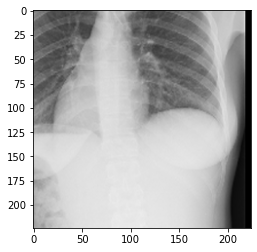

In [11]:
image= tf.keras.preprocessing.image.img_to_array(generator_train[0][0][5])
print(image.shape)
plt.imshow(image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


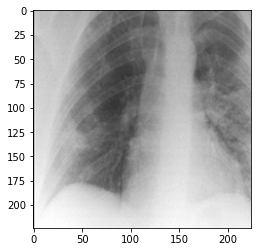

In [12]:
image= tf.keras.preprocessing.image.img_to_array(generator_validation[0][0][5])
print(image.shape)
plt.imshow(image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


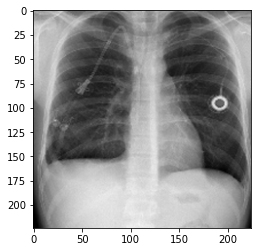

In [13]:
image= tf.keras.preprocessing.image.img_to_array(generator_test[0][0][5])
print(image.shape)
plt.imshow(image)
plt.show()

In [14]:
batch_size=32
int(np.ceil(generator_train.n / float(batch_size)))

348

In [15]:
generator_train.n / float(batch_size)

347.4375

In [16]:
y_true = generator_test.classes
y_true

[2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


### Verificación (5 pts.):

Muestre al menos 5 imágenes de cada uno de los conjuntos, asegurándose de que se cumple con lo establecido en el paso de preprocesamiento.

In [16]:
# Su código acá.

### Modelo (20 pts.)

Para entrenar nuestro algoritmo utilizaremos un famoso modelo llamado [ResNet](https://arxiv.org/abs/1512.03385) (He et al. 2015). El cual consistirá en un modelo que cuenta con 50 capas convolucionales residuales (ResNet50). 
Para obtener mejores resultados, en lugar de inicializar los pesos de manera aleatoria, se inicializarán utilizando los pesos de una red entrenada sobre [ImageNet](http://www.image-net.org/) (la competencia de clasificación de imágenes más famosa en visión computacional).
La capa de salida de esta arquitectura será reemplazada por una capa lineal de 3 nodos, con función de activación softmax, que nos dará la probabilidad para cada uno de nuestras clases.

Para entrenar este modelo:
1. Ocupe Adam como optimizador, utilizando un learning rate de 0.00001.
2. Reporte las métricas de accuracy y f1-score.
3. Ocupe como criterio de convergencia EarlyStopping (si la metrica f1-score macro no mejora durante más de 10 épocas sobre el conjunto de validación, entonces el entrenamiento debe detenerse).
4. Guarde los pesos del modelo entrenado sólo si éste presenta mejoras en la métrica de f1-score macro (medida sobre el conjunto de validación)


In [11]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(data_train['Condition']),
                                                 np.asarray(data_train['Condition']))
 
balanced_weights = dict(enumerate(class_weights))

C:\Users\hecag\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=['COVID-19' 'normal' 'pneumonia'], y=['pneumonia' 'pneumonia' 'pneumonia' ... 'pneumonia' 'pneumonia'
 'pneumonia'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [12]:
balanced_weights

{0: 9.793516560958421, 1: 0.5815130973303205, 2: 0.8487235861732014}

In [13]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)]

In [14]:
model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [21]:
fl1 = Flatten()(model.output)
fc1 = Dense(3, activation='softmax')(fl1)
model = Model(inputs=model.input, outputs=fc1)

In [22]:
from tensorflow.keras.optimizers import SGD, Adam
adam = Adam(lr=0.00001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy',get_f1])

In [23]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3998019754740831027
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13069104124520430969
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6067376473607448993
physical_device_desc: "device: XLA_GPU device"
]


In [24]:
epochs = 15
batch_size=32
history = model.fit_generator(
    generator_train,
    steps_per_epoch=int(np.ceil(generator_train.n / float(batch_size))),
    epochs=epochs,
    verbose=1,
    callbacks=my_callbacks,
    class_weight=balanced_weights,
    validation_data=generator_validation,
    validation_steps=int(np.ceil(generator_validation.n / float(batch_size)))
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
 10/348 [..............................] - ETA: 2:46:58 - loss: 1.0167 - accuracy: 0.5156 - get_f1: 0.5014

KeyboardInterrupt: 

### Curvas de aprendizaje (5 pts.):

Muestre las curvas de aprendizaje obtenidas luego del entrenamiento, tanto para la función de costos como para las métricas exigidas.

### Metrica final (10 pts.)

Muestre la matriz de confusión obtenida sobre los datos de test. Debería obtener algo como lo que se muestra a continuación.

In [ ]:
cm_matrix = confusion_matrix(ys, preds)
plot_confusion_matrix(cm_matrix, ['Normal', 'Pneumonia', 'Covid-19'], normalize=False)

## BONUS (5 pts.):

Tanto en el paper como en esta implementación existe un error metodológico muy común, pero a la misma vez muy grave, el cual dice relación con los conjuntos de datos. Diga cuál es este error y porqué es importante corregirlo.

In [ ]:
# Su respuesta acá